In [58]:
# LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


import geopandas as gpd
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import descartes
import math
import matplotlib.colors as mcolors
import pyproj
import folium

import geopandas as gpd
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import descartes
import math
import matplotlib.colors as mcolors
import pyproj
import folium
import contextily as ctx
from shapely.geometry import box
import xarray as xr
import matplotlib.animation as animation
import os
from branca.colormap import linear
from shapely.wkt import loads
from scipy.spatial import cKDTree
from sklearn.ensemble import RandomForestRegressor

In [59]:
# DATOS OBSERVACIONES
wdir = "../Dades/AMS_Observacions/"
crs_latlon = 'EPSG:4326'  # WGS84
crs_utm = "EPSG:32631"

In [60]:
# LIMPIAR DATOS OBSERVACIONES


df_no2 = pd.read_csv('../Dades/AMS_Observacions/gene_sconcno2_2023_xvpca_emep_port.csv') 
df_estacions = pd.read_csv('../Dades/AMS_Observacions/XVPCA_info_sconcno2_2023.csv')


# Convert 'Date' column to datetime format
df_no2['Date'] = pd.to_datetime(df_no2['Date'])

# Pivot the dataframe to have each station ID as a column and the Date as the index
# columnas_es = [col for col in df_no2.columns if col.startswith('ES')]
columnas_es =df_no2.drop(['Date'], axis=1)


# Transpose the dataframe to have each station ID as a row and the Date as the column
df_no2_transposed = df_no2.set_index('Date').transpose().reset_index()

# Melt the dataframe to have a 'Value' column for each hour
df_no2_melted = pd.melt(df_no2_transposed, id_vars=['index'], var_name='Date', value_name='no2')

# Rename the 'index' column to 'Station'
df_no2_melted.rename(columns={'index': 'Station'}, inplace=True)

# Drop rows with NaN values
df_no2_melted.dropna(subset=['no2'], inplace=True)

print(df_no2_melted)

# Join the melted dataframe with the station information dataframe
df_obs = pd.merge(df_no2_melted, df_estacions, left_on='Station', right_on='code', how='inner')

# Drop the 'code' column as it is redundant
df_obs.drop(columns=['code','type'], inplace=True)
df_obs['geometry'] = gpd.points_from_xy(df_obs['lon'], df_obs['lat'], crs=crs_utm)
print(df_obs)

        Station                 Date   no2
2       ES1480A  2022-12-31 23:00:00  62.0
3       ES1396A  2022-12-31 23:00:00  60.0
4       ES1992A  2022-12-31 23:00:00  45.0
5       ES0691A  2022-12-31 23:00:00  43.0
6       ES0692A  2022-12-31 23:00:00  45.0
...         ...                  ...   ...
560633  ES2017A  2023-12-31 22:00:00   7.0
560634  ES1930A  2023-12-31 22:00:00   1.0
560635  ES1948A  2023-12-31 22:00:00   3.0
560636  ES1855A  2023-12-31 22:00:00   2.0
560637  ES1854A  2023-12-31 22:00:00   1.0

[529219 rows x 3 columns]
        Station                 Date   no2        lat       lon  \
0       ES1480A  2022-12-31 23:00:00  62.0  41.398762  2.153472   
1       ES1396A  2022-12-31 23:00:00  60.0  41.378803  2.133098   
2       ES1992A  2022-12-31 23:00:00  45.0  41.387273  2.115661   
3       ES0691A  2022-12-31 23:00:00  43.0  41.403716  2.204736   
4       ES0692A  2022-12-31 23:00:00  45.0  41.370760  2.114771   
...         ...                  ...   ...        ...  

In [61]:
# # CARGAR CARRETERAS

# # Cargar el shapefile
# archivo_shapefile = "../Dades/OpenTransportMap/Barcelona/roadlinks_ES511.shp"
# gdf_barcelona = gpd.read_file(archivo_shapefile)
# gdf_girona = gpd.read_file("../Dades/OpenTransportMap/Girona/roadlinks_ES512.shp")
# gdf_lleida = gpd.read_file("../Dades/OpenTransportMap/Lleida/roadlinks_ES513.shp")
# gdf_tarragona = gpd.read_file("../Dades/OpenTransportMap/Tarragona/roadlinks_ES514.shp")

# # Concatenate the GeoDataFrames
# #gdf = pd.concat([gdf_barcelona, gdf_girona, gdf_lleida, gdf_tarragona], ignore_index=True)

# gdf = gdf_barcelona


# # Mostrar las primeras filas de la tabla de atributos
# #print(gdf['functional'].head())

# # Obtener los tipos únicos de la columna 'functional'
# tipos_functional = gdf['functional'].unique()

# # Asignar valores de prioridad a las categorías
# valores_prioridad = {
#     'mainRoad': 6 / 6,
#     'firstClass': 5 / 6,
#     'secondClass': 4 / 6,
#     'thirdClass': 3 / 6,
#     'fourthClass': 2 / 6,
#     'fifthClass': 1 / 6,    
# }

# # Crear una nueva columna en el GeoDataFrame con los valores de prioridad
# gdf['prioridad'] = gdf['functional'].map(valores_prioridad)

# # Crear un nuevo DataFrame con las columnas 'sourceid', 'functional' y 'prioridad'
# df_transport = gdf[['sourceid', 'prioridad','geometry']].drop_duplicates().reset_index(drop=True)
# # Simplificar la geometría
# df_transport['geometry'] = df_transport['geometry'].simplify(tolerance=0.01, preserve_topology=True)

# print(df_transport.head())

# # Guardar el GeoDataFrame en un archivo CSV
#gdf.to_csv("./carreteres.csv", index=False)


In [62]:
# CARGAR CALIOPE NO3 Y COMBINAR CON OBSERVACIONES

df_caliope = pd.read_csv('../Dades/NO2.csv') 

df_caliope.rename(columns={'sconcno2': 'no2', 'time': 'Date'}, inplace=True)

df_caliope['geometry'] = gpd.points_from_xy(df_caliope['lon'], df_caliope['lat'], crs=crs_utm)

df_combined = pd.concat([df_obs, df_caliope], ignore_index=True)

# Convert df_combined to a GeoDataFrame
df_combined = gpd.GeoDataFrame(df_combined, geometry='geometry', crs=crs_utm)

# Display the first few rows to verify the conversion
df_combined.head()


# Agrupar por 'geometry' y calcular la media de 'no2'
df_combined_mean = df_combined.groupby('geometry')['no2'].mean().reset_index()

# Mostrar el resultado
print("Max NO2:", df_combined_mean['no2'].max())
print("Min NO2:", df_combined_mean['no2'].min())

Max NO2: 34.580633549316055
Min NO2: 0.00010403053067096775


In [63]:
# SMALLER SAMPLE SIZE

# Use a smaller subset of the data for kriging
print(df_combined_mean.shape)
subset_size = 10000  # Adjust this value based on available memory
df_subset = df_combined_mean.sample(n=subset_size, random_state=42)

# TEST



(82908, 2)


In [64]:
domain_polygon = gpd.read_file("../Dades/Hands-on_Downscaling/Data_python/def_domini_bcn.geojson")


minx, miny, maxx, maxy = domain_polygon.total_bounds

# Crear la cuadrícula de 150m x 150m
cell_size = 500  # Tamaño de cada celda en metros
x_coords = np.arange(minx, maxx, cell_size)
y_coords = np.arange(miny, maxy, cell_size)

grid_cells = [box(x, y, x + cell_size, y + cell_size) for x in x_coords for y in y_coords]
grid = gpd.GeoDataFrame(grid_cells, columns=["geometry"], crs=crs_utm)

# Recortar la cuadrícula al área de Barcelona
grid_bcn = gpd.overlay(grid, domain_polygon, how="intersection")

# Convertir a WGS84 para usar en Folium
grid_bcn_wgs84 = grid_bcn.to_crs(epsg=4326)

# Calcular los puntos centrales de las celdas (centroides)
grid_bcn_wgs84["centroid"] = grid_bcn_wgs84.geometry.centroid

/tmp/ipykernel_56492/266693956.py:15: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:32631
Right CRS: EPSG:4326

  grid_bcn = gpd.overlay(grid, domain_polygon, how="intersection")
/tmp/ipykernel_56492/266693956.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_bcn_wgs84["centroid"] = grid_bcn_wgs84.geometry.centroid


In [65]:
# Crear un nuevo GeoDataFrame a partir de grid_bcn_wgs84["geometry"]
grid_gdf = gpd.GeoDataFrame(geometry=grid_bcn_wgs84["centroid"], crs=crs_latlon)
centroid_list = list(grid_gdf["geometry"])
# Mostrar las primeras filas
print(centroid_list)

[<POINT (2.055 41.319)>, <POINT (2.055 41.323)>, <POINT (2.055 41.327)>, <POINT (2.055 41.332)>, <POINT (2.055 41.336)>, <POINT (2.055 41.341)>, <POINT (2.055 41.345)>, <POINT (2.055 41.35)>, <POINT (2.055 41.354)>, <POINT (2.055 41.359)>, <POINT (2.055 41.363)>, <POINT (2.055 41.368)>, <POINT (2.055 41.372)>, <POINT (2.055 41.377)>, <POINT (2.055 41.381)>, <POINT (2.055 41.386)>, <POINT (2.055 41.39)>, <POINT (2.055 41.395)>, <POINT (2.055 41.399)>, <POINT (2.055 41.404)>, <POINT (2.055 41.408)>, <POINT (2.055 41.413)>, <POINT (2.055 41.417)>, <POINT (2.055 41.422)>, <POINT (2.055 41.426)>, <POINT (2.054 41.431)>, <POINT (2.054 41.435)>, <POINT (2.054 41.44)>, <POINT (2.054 41.444)>, <POINT (2.054 41.449)>, <POINT (2.054 41.453)>, <POINT (2.054 41.458)>, <POINT (2.054 41.462)>, <POINT (2.054 41.466)>, <POINT (2.061 41.319)>, <POINT (2.061 41.323)>, <POINT (2.061 41.327)>, <POINT (2.061 41.332)>, <POINT (2.061 41.336)>, <POINT (2.061 41.341)>, <POINT (2.061 41.345)>, <POINT (2.061 41.3

In [66]:
# PREDICCION

from scipy.spatial import cKDTree
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

# Crear GeoDataFrame con puntos de predicción
obs_locations = gpd.GeoDataFrame(
    {'geometry': centroid_list},
    crs=crs_utm
)

# Extraer coordenadas y valores del dataset conocido
coords = np.array([(geom.x, geom.y) for geom in df_combined_mean.geometry])
values = df_combined_mean['no2'].values

# Crear el árbol KD
tree = cKDTree(coords)

# Función IDW
def idw(x, y, tree, coords, values, power=2):
    """
    Interpolación por inverso de la distancia (IDW).
    - x, y: Coordenadas de predicción
    - tree: KDTree construido con los datos conocidos
    - coords: Coordenadas conocidas
    - values: Valores conocidos
    - power: Peso de la distancia
    """
    # Encontrar distancias y vecinos
    distances, idx = tree.query(np.c_[x, y], k=len(coords))
    
    # Manejo de distancias 0 (puntos coincidentes)
    distances[distances == 0] = 1e-10  # Evitar división por cero
    
    # Calcular pesos inversos a las distancias
    weights = 1 / distances**power
    
    # Normalizar los pesos
    weights /= np.sum(weights, axis=1, keepdims=True)
    
    # Calcular valores interpolados
    interpolated_values = np.sum(weights * values[idx], axis=1)
    return interpolated_values

# Coordenadas de los puntos a predecir
prediction_coords = np.array([(geom.x, geom.y) for geom in obs_locations.geometry])
x_pred, y_pred = prediction_coords[:, 0], prediction_coords[:, 1]

# Aplicar IDW a los puntos
obs_locations['predicted_value'] = idw(x_pred, y_pred, tree, coords, values)


Estadísticas originales 'obs_locations':
count    1020.000000
mean        0.673682
std         1.260311
min         0.013112
25%         0.211874
50%         0.341792
75%         0.655999
max        13.070395
Name: predicted_value, dtype: float64
85th percentile: 0.942345655124709


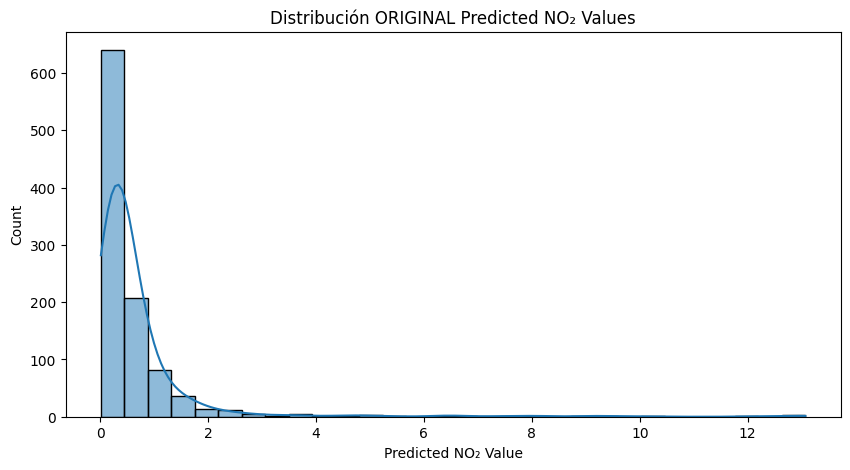

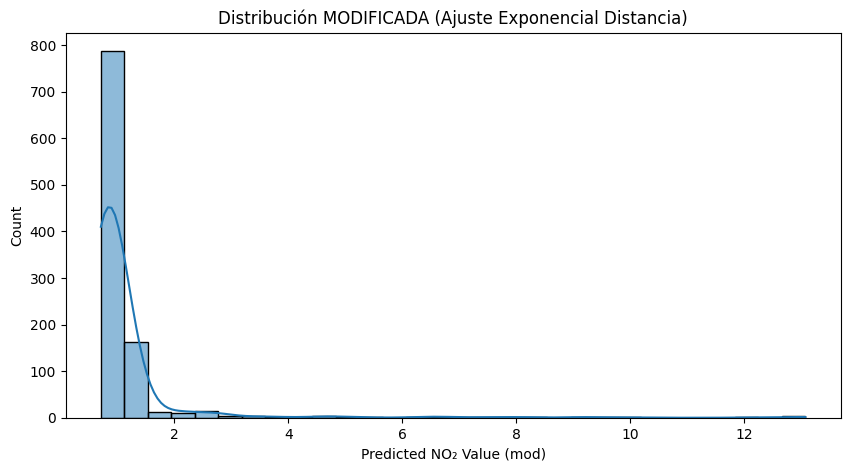

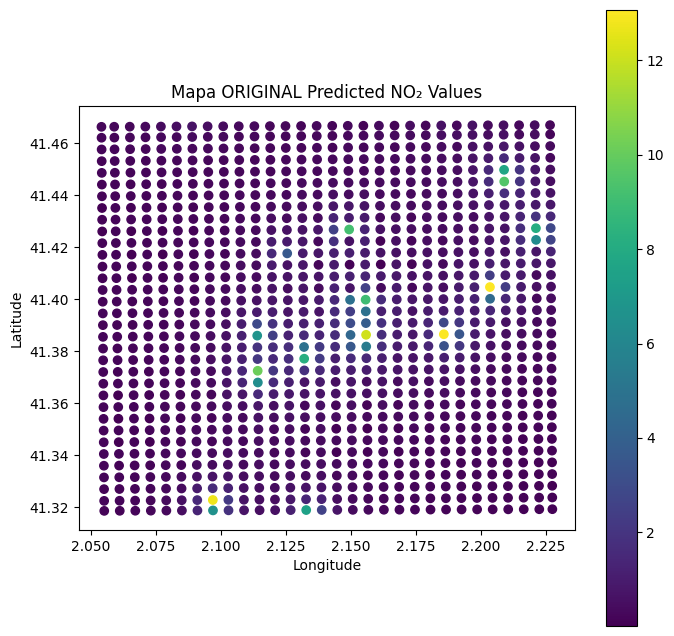

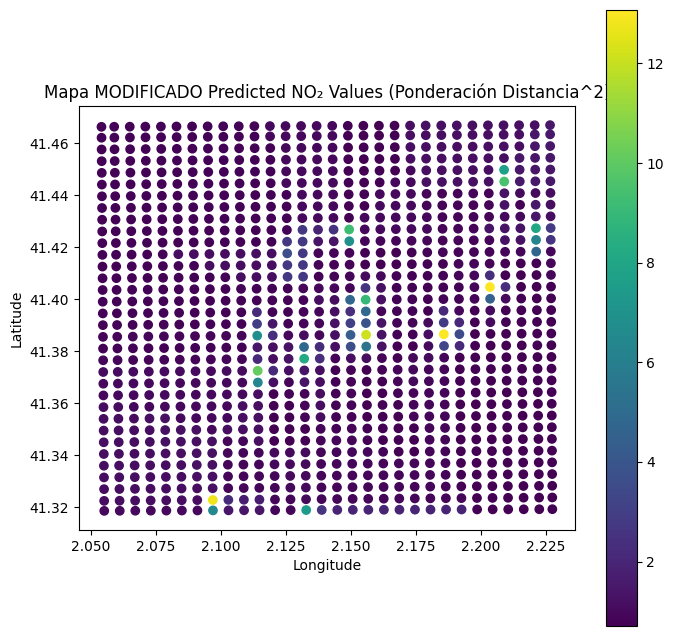


Estadísticas finales (mod_obs_locations):
       predicted_value  predicted_value_normalized  predicted_value_mod
count      1020.000000                 1020.000000          1020.000000
mean          0.673682                    0.673682             1.123878
std           1.260311                    1.260311             1.180356
min           0.013112                    0.013112             0.708880
25%           0.211874                    0.211874             0.758505
50%           0.341792                    0.341792             0.857024
75%           0.655999                    0.655999             1.096874
max          13.070395                   13.070395            13.070395

Ejemplos de filas:
   predicted_value  predicted_value_normalized  predicted_value_mod  \
0         0.141991                    0.141991             0.967977   
1         0.168640                    0.168640             1.130894   
2         0.159588                    0.159588             1.130893   
3    

In [ ]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Para histogram equalization
from skimage.exposure import equalize_hist

# -----------------------------------------------------------------------------
# COPIA para no alterar obs_locations original
# -----------------------------------------------------------------------------
mod_obs_locations = obs_locations.copy()

print("Estadísticas originales 'obs_locations':")
print(obs_locations['predicted_value'].describe())

# -----------------------------------------------------------------------------
# 1. Cálculo del percentil (valores "altos")
# -----------------------------------------------------------------------------
pct_threshold = 0.85  # o 0.90, 0.95... mientras más alto, más "selecto" es el grupo de valores altos
percentile_value = mod_obs_locations['predicted_value'].quantile(pct_threshold)
print(f"{int(pct_threshold*100)}th percentile:", percentile_value)

# -----------------------------------------------------------------------------
# 2. Normalización parcial debajo del percentil
# -----------------------------------------------------------------------------
low_mask = mod_obs_locations['predicted_value'] < percentile_value
high_mask = mod_obs_locations['predicted_value'] >= percentile_value

low_min = mod_obs_locations.loc[low_mask, 'predicted_value'].min()
low_max = mod_obs_locations.loc[low_mask, 'predicted_value'].max()
if low_max == low_min:
    low_max = low_min + 1e-9

def partial_minmax_scale(value):
    """Reescala [low_min, percentile_value] -> [low_min, percentile_value] en modo min-max agresivo."""
    return ((value - low_min) / (percentile_value - low_min)) * (percentile_value - low_min) + low_min

mod_obs_locations['predicted_value_normalized'] = mod_obs_locations['predicted_value']
mod_obs_locations.loc[low_mask, 'predicted_value_normalized'] = mod_obs_locations.loc[low_mask, 'predicted_value'].apply(partial_minmax_scale)

# -----------------------------------------------------------------------------
# 3. Ajuste gradual por distancia para valores muy bajos
#    con una potencia mayor (distance_power=3 o 4) para intensificar el cambio
# -----------------------------------------------------------------------------
distance_threshold = 10    # metros
distance_power = 3         # mayor potencia => corrección + fuerte cerca del punto alto
floor_factor = 0.75        # factor: sube al 75% del valor alto
min_value_cutoff = 2.0     # por debajo de este valor, aplicamos corrección

high_points = mod_obs_locations[mod_obs_locations['predicted_value_normalized'] >= percentile_value].copy()

def gradual_fix_low_values(row, high_points, distance_threshold, min_value_cutoff, floor_factor, distance_power):
    current_val = row['predicted_value_normalized']
    if current_val >= min_value_cutoff:
        return current_val
    
    if high_points.empty:
        return current_val
    
    geom = row.geometry
    dists = high_points.geometry.distance(geom)
    nearest_dist = dists.min()
    if nearest_dist > distance_threshold:
        return current_val
    
    nearest_val = high_points.loc[dists.idxmin(), 'predicted_value_normalized']
    floor_value = floor_factor * nearest_val
    
    # Fracción decrece según dist^distance_power
    frac = 1 - (nearest_dist / distance_threshold)**distance_power
    frac = np.clip(frac, 0, 1)
    
    corrected_val = current_val + frac * (floor_value - current_val)
    return corrected_val

mod_obs_locations['predicted_value_mod'] = mod_obs_locations.apply(
    lambda row: gradual_fix_low_values(row, high_points, distance_threshold,
                                       min_value_cutoff, floor_factor, distance_power),
    axis=1
)

# -----------------------------------------------------------------------------
# 4. Aumentar el contraste final de la distribución
#    a) Opción 1: Histogram Equalization (skimage.exposure.equalize_hist)
#    b) Opción 2: Quantile Transformer para una distribución ~ uniforme
# -----------------------------------------------------------------------------

# a) Histogram Equalization con skimage
values_array = mod_obs_locations['predicted_value_mod'].values
values_array = values_array - values_array.min()  # asegurar no negativos
if (values_array.max() - values_array.min()) > 0:
    values_array = values_array / values_array.max()  # normalizar a [0,1]
else:
    values_array = values_array * 0  # trivial si todos los valores son iguales

eq_values = equalize_hist(values_array)  # mapea a [0,1] con hist eq
# reescalar a un rango "realista", p. ej. [0, max_original]
max_original = obs_locations['predicted_value'].max()
final_values = eq_values * max_original  # o un rango que te interese

mod_obs_locations['predicted_value_final'] = final_values

# -----------------------------------------------------------------------------
# 5. Visualizaciones de histogramas y mapas
# -----------------------------------------------------------------------------
# Histograma ORIGINAL
plt.figure(figsize=(10, 5))
sns.histplot(obs_locations['predicted_value'], bins=30, kde=True)
plt.title('Distribución ORIGINAL Predicted NO₂ Values')
plt.xlabel('Predicted NO₂ Value')
plt.show()

# Histograma MODIFICADO (con eq)
plt.figure(figsize=(10, 5))
sns.histplot(mod_obs_locations['predicted_value_final'], bins=30, kde=True)
plt.title('Distribución MODIFICADA (Ajuste Gradual + HistEqualization)')
plt.xlabel('Predicted NO₂ Value (Final)')
plt.show()

# Mapas: original vs modificado
obs_locations.plot(column='predicted_value', cmap='viridis', legend=True, figsize=(8, 8))
plt.title('Mapa ORIGINAL Predicted NO₂ Values')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

mod_obs_locations.plot(column='predicted_value_final', cmap='viridis', legend=True, figsize=(8, 8))
plt.title('Mapa FINAL (Gradual + HistEqualization)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# -----------------------------------------------------------------------------
# 6. Estadísticas finales
# -----------------------------------------------------------------------------
print("\nEstadísticas finales (mod_obs_locations):")
print(mod_obs_locations[['predicted_value', 'predicted_value_normalized', 
                         'predicted_value_mod', 'predicted_value_final']].describe())

print("\nEjemplos de filas (mod_obs_locations):")
print(mod_obs_locations[['predicted_value', 'predicted_value_normalized', 
                         'predicted_value_mod', 'predicted_value_final', 'geometry']].head(10))


In [ ]:
# Crear un rango de colores basado en predicted_value
colormap = linear.viridis.scale(
    mod_obs_locations['predicted_value'].min(),
    mod_obs_locations['predicted_value'].max()
)
colormap.caption = "NO₂ Predicted Concentration"

# Crear un mapa centrado en las coordenadas promedio de los puntos
map_center = [
    mod_obs_locations.geometry.y.mean(),
    mod_obs_locations.geometry.x.mean()
]
m = folium.Map(location=map_center, zoom_start=12)

# Agregar los puntos al mapa
for _, row in obs_locations.iterrows():
    color = colormap(row['predicted_value'])  # Obtener el color para el valor
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],  # Coordenadas del punto
        radius=5,  # Tamaño del marcador
        color=color,  # Color del borde
        fill=True,
        fill_color=color,  # Color del relleno
        fill_opacity=0.7,
        popup=f"NO₂: {row['predicted_value']:.2f}"  # Información desplegable
    ).add_to(m)

# Agregar la barra de colores al mapa
colormap.add_to(m)

# Mostrar el mapa
m

In [69]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Archivo: mi_idw_pesado.py
Descripción: Ejemplo de interpolación por IDW con factores de peso diferenciados.
             No guarda el mapa en un archivo HTML.
"""

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree
import folium
from branca.colormap import linear

# -----------------------------------------------------------------------------
# 1. Simulación / Carga de datos (DataFrame de puntos conocidos)
# -----------------------------------------------------------------------------
# Este bloque simula un DataFrame con 5 puntos y sus colores.
# En tu caso real, reemplaza esto cargando tus datos reales.

df_combined_mean = gpd.GeoDataFrame({'geometry': centroid_list}, crs=crs_utm)

# Suponiendo una proyección UTM EPSG:25831 (por ejemplo, en España).
df_combined_mean.set_crs(epsg=25831, inplace=True, allow_override=True)
crs_utm = df_combined_mean.crs

# -----------------------------------------------------------------------------
# 2. Asignar factor de peso a cada punto (depende del color u otros criterios)
# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# 3. Construir KDTree y preparar arrays
# -----------------------------------------------------------------------------
coords = np.array([(geom.x, geom.y) for geom in df_combined_mean.geometry])
print(df_combined_mean.columns)

weights_factor = df_combined_mean['weight'].values

tree = cKDTree(coords)

# -----------------------------------------------------------------------------
# 4. Definir la función IDW con factor de peso adicional
# -----------------------------------------------------------------------------
def idw(x, y, tree, coords, values, weights_factor, power=2):
    """
    Interpolación por inverso de la distancia (IDW) con factor de peso adicional.
    
    - x, y: Arrays de coordenadas de predicción
    - tree: KDTree con datos conocidos
    - coords: np.array (N,2) de coordenadas de puntos conocidos
    - values: np.array de valores (e.g., NO2)
    - weights_factor: np.array con factores de peso (mismo orden que 'values')
    - power: exponente para IDW (por defecto 2)
    """
    distances, idx = tree.query(np.c_[x, y], k=len(coords))
    
    # Evitar división por cero cuando un punto coincide exactamente
    distances[distances == 0] = 1e-10
    
    # Peso base = 1 / distancia^power
    base_weights = 1.0 / distances**power
    
    # Multiplicar por el factor de peso según cada punto (weights_factor)
    weights = base_weights * weights_factor[idx]
    
    # Normalizar pesos en cada fila
    weights_sum = np.sum(weights, axis=1, keepdims=True)
    weights /= weights_sum
    
    # Calcular valor interpolado
    interpolated_values = np.sum(weights * values[idx], axis=1)
    return interpolated_values

# -----------------------------------------------------------------------------
# 5. Generar la grilla de predicción (obs_locations)
# -----------------------------------------------------------------------------
# Definimos una grilla de 10x10 puntos dentro del bounding box de los datos.
# En tu caso, podrías tener un listado de centroides real.
# -----------------------------------------------------------------------------
minx, miny, maxx, maxy = df_combined_mean.total_bounds  # (xmin, ymin, xmax, ymax)
n_points = 10

x_range = np.linspace(minx, maxx, n_points)
y_range = np.linspace(miny, maxy, n_points)

centroid_list = []
for xi in x_range:
    for yi in y_range:
        centroid_list.append(Point(xi, yi))

obs_locations = gpd.GeoDataFrame({'geometry': centroid_list}, crs=crs_utm)

# -----------------------------------------------------------------------------
# 6. Aplicar IDW a la grilla de predicción
# -----------------------------------------------------------------------------
prediction_coords = np.array([(geom.x, geom.y) for geom in obs_locations.geometry])
x_pred, y_pred = prediction_coords[:, 0], prediction_coords[:, 1]

obs_locations['predicted_value'] = idw(
    x_pred, y_pred,
    tree, coords, values,
    weights_factor=weights_factor,  # factor de peso adicional
    power=2
)

print(obs_locations.head())
mean_prediction = obs_locations['predicted_value'].mean()
print("Mean prediction:", mean_prediction)

# -----------------------------------------------------------------------------
# 7. Visualizar con Folium (no se guarda en HTML)
# -----------------------------------------------------------------------------
colormap = linear.viridis.scale(
    obs_locations['predicted_value'].min(),
    obs_locations['predicted_value'].max()
)
colormap.caption = "NO₂ Predicted Concentration"

map_center = [
    obs_locations.geometry.y.mean(),
    obs_locations.geometry.x.mean()
]
m = folium.Map(location=map_center, zoom_start=14)

for _, row in obs_locations.iterrows():
    color = colormap(row['predicted_value'])
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"NO₂: {row['predicted_value']:.2f}"
    ).add_to(m)

colormap.add_to(m)

# Si corres esto en Jupyter/Colab, haz display(m) para mostrar el mapa interactivo.
m


Index(['geometry'], dtype='object')


KeyError: 'weight'